# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Jun 17 21:07:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   51C    P0             17W /  170W |    1341MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.1+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

Random image path: data\pizza_steak_sushi\train\pizza\2811032.jpg
Image class: pizza
Image height: 512
Image width: 512


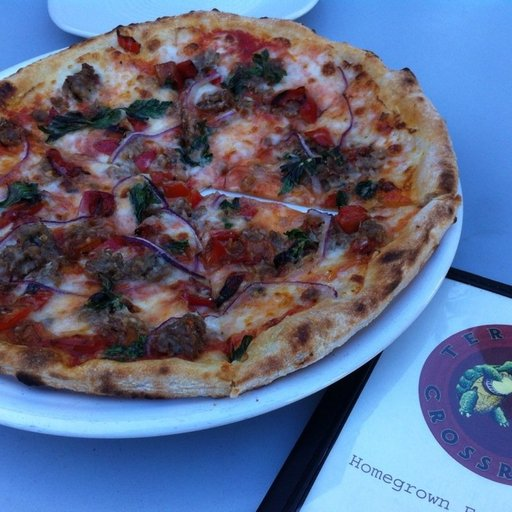

In [7]:
# Visualize an image
import random
from PIL import Image

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

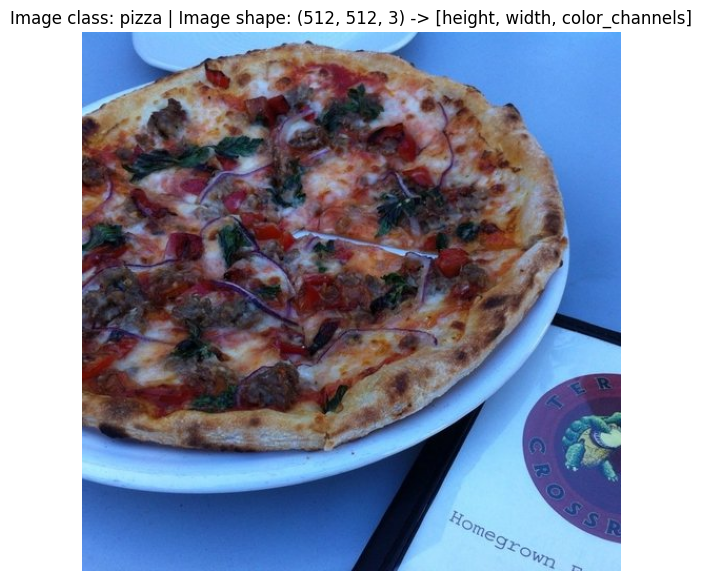

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

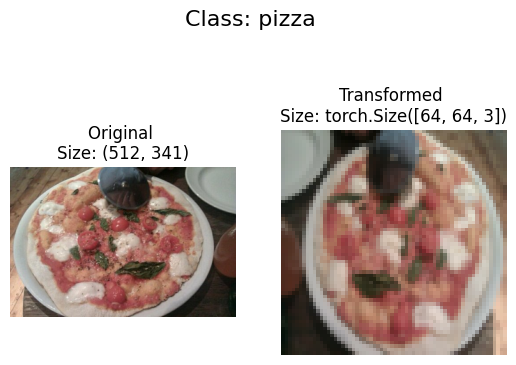

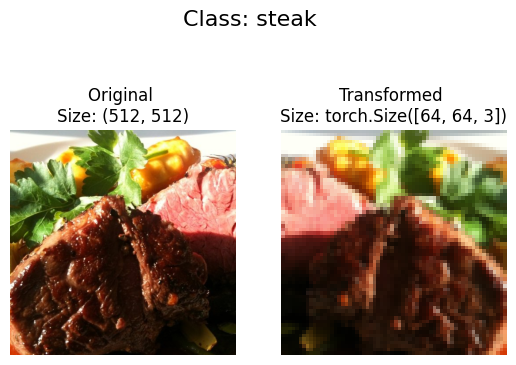

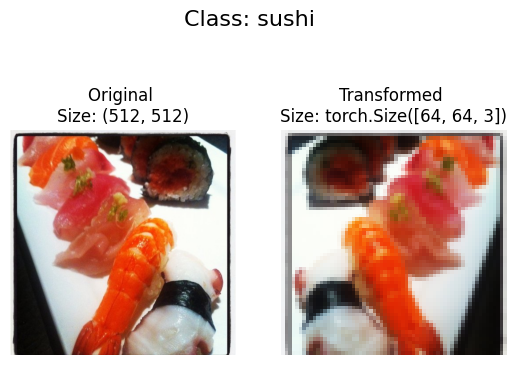

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=os.cpu_count(), 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e6582e9400>,
 <torch.utils.data.dataloader.DataLoader at 0x1e658245730>)

In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [19]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [21]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

c:\Users\Stepan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [30]:
# Train for 5 epochs
# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0_5 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_5.parameters(),
                             lr=0.001)

# Train model_0_5 
model_0_5_results = train(model=model_0_5, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

 20%|██        | 1/5 [00:10<00:41, 10.35s/it]

Epoch: 1 | train_loss: 1.1029 | train_acc: 0.2978 | test_loss: 1.0988 | test_acc: 0.3333


 40%|████      | 2/5 [00:20<00:30, 10.11s/it]

Epoch: 2 | train_loss: 1.0992 | train_acc: 0.3467 | test_loss: 1.0993 | test_acc: 0.3333


 60%|██████    | 3/5 [00:30<00:19,  9.98s/it]

Epoch: 3 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.0998 | test_acc: 0.3333


 80%|████████  | 4/5 [00:40<00:10, 10.02s/it]

Epoch: 4 | train_loss: 1.1000 | train_acc: 0.3289 | test_loss: 1.0998 | test_acc: 0.3333


100%|██████████| 5/5 [00:50<00:00, 10.02s/it]

Epoch: 5 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1002 | test_acc: 0.3333


In [31]:
# Train for 20 epochs
# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0_20 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_20.parameters(),
                             lr=0.001)

# Train model_0_20 
model_0_20_results = train(model=model_0_20, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  5%|▌         | 1/20 [00:09<03:07,  9.88s/it]

Epoch: 1 | train_loss: 1.0992 | train_acc: 0.3556 | test_loss: 1.0645 | test_acc: 0.4400


 10%|█         | 2/20 [00:19<02:58,  9.93s/it]

Epoch: 2 | train_loss: 1.0325 | train_acc: 0.4844 | test_loss: 1.0253 | test_acc: 0.4933


 15%|█▌        | 3/20 [00:29<02:48,  9.93s/it]

Epoch: 3 | train_loss: 0.9396 | train_acc: 0.5778 | test_loss: 0.9585 | test_acc: 0.5067


 20%|██        | 4/20 [00:39<02:39,  9.97s/it]

Epoch: 4 | train_loss: 0.8855 | train_acc: 0.5867 | test_loss: 0.9927 | test_acc: 0.4533


 25%|██▌       | 5/20 [00:49<02:29,  9.95s/it]

Epoch: 5 | train_loss: 0.8398 | train_acc: 0.6133 | test_loss: 1.0030 | test_acc: 0.4800


 30%|███       | 6/20 [00:59<02:17,  9.82s/it]

Epoch: 6 | train_loss: 0.8275 | train_acc: 0.6267 | test_loss: 0.9508 | test_acc: 0.4533


 35%|███▌      | 7/20 [01:09<02:07,  9.80s/it]

Epoch: 7 | train_loss: 0.8174 | train_acc: 0.6356 | test_loss: 0.9849 | test_acc: 0.4667


 40%|████      | 8/20 [01:18<01:56,  9.70s/it]

Epoch: 8 | train_loss: 0.7947 | train_acc: 0.6400 | test_loss: 1.0962 | test_acc: 0.4533


 45%|████▌     | 9/20 [01:28<01:46,  9.72s/it]

Epoch: 9 | train_loss: 0.7544 | train_acc: 0.6622 | test_loss: 1.1402 | test_acc: 0.4267


 50%|█████     | 10/20 [01:38<01:37,  9.77s/it]

Epoch: 10 | train_loss: 0.7221 | train_acc: 0.6844 | test_loss: 1.0382 | test_acc: 0.4800


 55%|█████▌    | 11/20 [01:47<01:27,  9.72s/it]

Epoch: 11 | train_loss: 0.6890 | train_acc: 0.7289 | test_loss: 1.0458 | test_acc: 0.4800


 60%|██████    | 12/20 [01:57<01:18,  9.83s/it]

Epoch: 12 | train_loss: 0.6248 | train_acc: 0.7644 | test_loss: 1.2414 | test_acc: 0.4400


 65%|██████▌   | 13/20 [02:07<01:08,  9.86s/it]

Epoch: 13 | train_loss: 0.6228 | train_acc: 0.7156 | test_loss: 1.1619 | test_acc: 0.4800


 70%|███████   | 14/20 [02:17<00:59,  9.86s/it]

Epoch: 14 | train_loss: 0.5180 | train_acc: 0.7733 | test_loss: 1.2242 | test_acc: 0.4933


 75%|███████▌  | 15/20 [02:27<00:48,  9.74s/it]

Epoch: 15 | train_loss: 0.5046 | train_acc: 0.7956 | test_loss: 1.3141 | test_acc: 0.5067


 80%|████████  | 16/20 [02:36<00:38,  9.75s/it]

Epoch: 16 | train_loss: 0.4457 | train_acc: 0.8222 | test_loss: 1.4432 | test_acc: 0.4400


 85%|████████▌ | 17/20 [02:46<00:29,  9.77s/it]

Epoch: 17 | train_loss: 0.4601 | train_acc: 0.8044 | test_loss: 1.4110 | test_acc: 0.5067


 90%|█████████ | 18/20 [02:56<00:19,  9.71s/it]

Epoch: 18 | train_loss: 0.3646 | train_acc: 0.8622 | test_loss: 1.5603 | test_acc: 0.4933


 95%|█████████▌| 19/20 [03:05<00:09,  9.71s/it]

Epoch: 19 | train_loss: 0.3126 | train_acc: 0.8800 | test_loss: 1.5587 | test_acc: 0.5067


100%|██████████| 20/20 [03:15<00:00,  9.79s/it]

Epoch: 20 | train_loss: 0.3104 | train_acc: 0.8711 | test_loss: 1.7273 | test_acc: 0.5333


In [32]:
# Train for 50 epochs
# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0_50 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_50.parameters(),
                             lr=0.001)

# Train model_0_50 
model_0_50_results = train(model=model_0_50, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  2%|▏         | 1/50 [00:09<08:04,  9.90s/it]

Epoch: 1 | train_loss: 1.1099 | train_acc: 0.3422 | test_loss: 1.0905 | test_acc: 0.4533


  4%|▍         | 2/50 [00:19<07:56,  9.92s/it]

Epoch: 2 | train_loss: 1.0331 | train_acc: 0.5289 | test_loss: 0.9860 | test_acc: 0.4800


  6%|▌         | 3/50 [00:29<07:40,  9.80s/it]

Epoch: 3 | train_loss: 0.9508 | train_acc: 0.5822 | test_loss: 0.9808 | test_acc: 0.4800


  8%|▊         | 4/50 [00:39<07:26,  9.72s/it]

Epoch: 4 | train_loss: 0.8642 | train_acc: 0.6400 | test_loss: 0.9447 | test_acc: 0.4800


 10%|█         | 5/50 [00:49<07:21,  9.82s/it]

Epoch: 5 | train_loss: 0.8671 | train_acc: 0.5867 | test_loss: 1.0948 | test_acc: 0.4800


 12%|█▏        | 6/50 [00:59<07:17,  9.93s/it]

Epoch: 6 | train_loss: 0.8083 | train_acc: 0.6400 | test_loss: 0.9669 | test_acc: 0.4933


 14%|█▍        | 7/50 [01:09<07:05,  9.89s/it]

Epoch: 7 | train_loss: 0.7847 | train_acc: 0.6356 | test_loss: 0.9891 | test_acc: 0.4933


 16%|█▌        | 8/50 [01:19<06:56,  9.92s/it]

Epoch: 8 | train_loss: 0.7700 | train_acc: 0.6844 | test_loss: 0.9579 | test_acc: 0.5333


 18%|█▊        | 9/50 [01:29<06:47,  9.94s/it]

Epoch: 9 | train_loss: 0.7101 | train_acc: 0.7200 | test_loss: 0.9987 | test_acc: 0.5467


 20%|██        | 10/50 [01:38<06:37,  9.95s/it]

Epoch: 10 | train_loss: 0.6143 | train_acc: 0.7467 | test_loss: 1.0891 | test_acc: 0.5467


 22%|██▏       | 11/50 [01:48<06:25,  9.88s/it]

Epoch: 11 | train_loss: 0.6347 | train_acc: 0.7289 | test_loss: 1.1194 | test_acc: 0.5200


 24%|██▍       | 12/50 [01:58<06:08,  9.70s/it]

Epoch: 12 | train_loss: 0.5579 | train_acc: 0.7822 | test_loss: 1.3325 | test_acc: 0.5200


 26%|██▌       | 13/50 [02:07<06:02,  9.79s/it]

Epoch: 13 | train_loss: 0.5728 | train_acc: 0.7422 | test_loss: 1.2043 | test_acc: 0.5067


 28%|██▊       | 14/50 [02:18<05:56,  9.90s/it]

Epoch: 14 | train_loss: 0.5046 | train_acc: 0.7911 | test_loss: 1.2163 | test_acc: 0.5467


 30%|███       | 15/50 [02:28<05:47,  9.92s/it]

Epoch: 15 | train_loss: 0.4842 | train_acc: 0.7911 | test_loss: 1.1737 | test_acc: 0.5333


 32%|███▏      | 16/50 [02:38<05:38,  9.95s/it]

Epoch: 16 | train_loss: 0.4164 | train_acc: 0.8178 | test_loss: 1.4175 | test_acc: 0.5333


 34%|███▍      | 17/50 [02:48<05:28,  9.96s/it]

Epoch: 17 | train_loss: 0.3995 | train_acc: 0.8533 | test_loss: 1.7051 | test_acc: 0.5733


 36%|███▌      | 18/50 [02:57<05:16,  9.89s/it]

Epoch: 18 | train_loss: 0.3544 | train_acc: 0.8533 | test_loss: 1.7184 | test_acc: 0.5467


 38%|███▊      | 19/50 [03:07<05:04,  9.83s/it]

Epoch: 19 | train_loss: 0.3802 | train_acc: 0.8667 | test_loss: 1.8063 | test_acc: 0.4933


 40%|████      | 20/50 [03:17<04:51,  9.73s/it]

Epoch: 20 | train_loss: 0.3080 | train_acc: 0.8978 | test_loss: 1.7003 | test_acc: 0.6133


 42%|████▏     | 21/50 [03:26<04:40,  9.68s/it]

Epoch: 21 | train_loss: 0.2750 | train_acc: 0.8889 | test_loss: 1.9329 | test_acc: 0.5600


 44%|████▍     | 22/50 [03:36<04:29,  9.63s/it]

Epoch: 22 | train_loss: 0.2422 | train_acc: 0.9067 | test_loss: 2.5501 | test_acc: 0.5200


 46%|████▌     | 23/50 [03:45<04:21,  9.69s/it]

Epoch: 23 | train_loss: 0.2248 | train_acc: 0.9200 | test_loss: 2.1198 | test_acc: 0.5333


 48%|████▊     | 24/50 [03:55<04:13,  9.73s/it]

Epoch: 24 | train_loss: 0.1713 | train_acc: 0.9511 | test_loss: 2.0632 | test_acc: 0.5600


 50%|█████     | 25/50 [04:05<04:03,  9.73s/it]

Epoch: 25 | train_loss: 0.1767 | train_acc: 0.9289 | test_loss: 2.4624 | test_acc: 0.5333


 52%|█████▏    | 26/50 [04:14<03:50,  9.59s/it]

Epoch: 26 | train_loss: 0.1674 | train_acc: 0.9378 | test_loss: 2.6448 | test_acc: 0.5600


 54%|█████▍    | 27/50 [04:24<03:42,  9.66s/it]

Epoch: 27 | train_loss: 0.1513 | train_acc: 0.9422 | test_loss: 3.1064 | test_acc: 0.4800


 56%|█████▌    | 28/50 [04:34<03:33,  9.72s/it]

Epoch: 28 | train_loss: 0.1588 | train_acc: 0.9289 | test_loss: 3.0394 | test_acc: 0.5200


 58%|█████▊    | 29/50 [04:44<03:26,  9.84s/it]

Epoch: 29 | train_loss: 0.0998 | train_acc: 0.9733 | test_loss: 3.5806 | test_acc: 0.5200


 60%|██████    | 30/50 [04:54<03:17,  9.90s/it]

Epoch: 30 | train_loss: 0.0507 | train_acc: 0.9867 | test_loss: 4.3295 | test_acc: 0.5200


 62%|██████▏   | 31/50 [05:04<03:07,  9.85s/it]

Epoch: 31 | train_loss: 0.0991 | train_acc: 0.9822 | test_loss: 4.3939 | test_acc: 0.4800


 64%|██████▍   | 32/50 [05:14<02:57,  9.86s/it]

Epoch: 32 | train_loss: 0.1168 | train_acc: 0.9644 | test_loss: 4.2190 | test_acc: 0.5200


 66%|██████▌   | 33/50 [05:24<02:47,  9.84s/it]

Epoch: 33 | train_loss: 0.0684 | train_acc: 0.9733 | test_loss: 4.1031 | test_acc: 0.4800


 68%|██████▊   | 34/50 [05:34<02:38,  9.89s/it]

Epoch: 34 | train_loss: 0.0573 | train_acc: 0.9867 | test_loss: 3.6750 | test_acc: 0.5867


 70%|███████   | 35/50 [05:43<02:28,  9.87s/it]

Epoch: 35 | train_loss: 0.0765 | train_acc: 0.9689 | test_loss: 4.4717 | test_acc: 0.5333


 72%|███████▏  | 36/50 [05:53<02:17,  9.80s/it]

Epoch: 36 | train_loss: 0.0641 | train_acc: 0.9778 | test_loss: 4.1666 | test_acc: 0.5333


 74%|███████▍  | 37/50 [06:03<02:06,  9.76s/it]

Epoch: 37 | train_loss: 0.0290 | train_acc: 0.9911 | test_loss: 4.4163 | test_acc: 0.5733


 76%|███████▌  | 38/50 [06:12<01:56,  9.75s/it]

Epoch: 38 | train_loss: 0.0229 | train_acc: 0.9867 | test_loss: 4.4786 | test_acc: 0.6133


 78%|███████▊  | 39/50 [06:22<01:46,  9.64s/it]

Epoch: 39 | train_loss: 0.0354 | train_acc: 0.9867 | test_loss: 4.8172 | test_acc: 0.5467


 80%|████████  | 40/50 [06:31<01:36,  9.66s/it]

Epoch: 40 | train_loss: 0.3092 | train_acc: 0.9244 | test_loss: 3.2545 | test_acc: 0.4667


 82%|████████▏ | 41/50 [06:42<01:28,  9.81s/it]

Epoch: 41 | train_loss: 0.1227 | train_acc: 0.9556 | test_loss: 3.9410 | test_acc: 0.5467


 84%|████████▍ | 42/50 [06:52<01:18,  9.87s/it]

Epoch: 42 | train_loss: 0.0300 | train_acc: 0.9956 | test_loss: 4.3814 | test_acc: 0.5467


 86%|████████▌ | 43/50 [07:01<01:08,  9.79s/it]

Epoch: 43 | train_loss: 0.0262 | train_acc: 0.9911 | test_loss: 4.3229 | test_acc: 0.5600


 88%|████████▊ | 44/50 [07:11<00:59,  9.86s/it]

Epoch: 44 | train_loss: 0.0168 | train_acc: 1.0000 | test_loss: 5.1620 | test_acc: 0.5067


 90%|█████████ | 45/50 [07:21<00:49,  9.94s/it]

Epoch: 45 | train_loss: 0.0208 | train_acc: 0.9956 | test_loss: 5.0640 | test_acc: 0.5467


 92%|█████████▏| 46/50 [07:31<00:39,  9.91s/it]

Epoch: 46 | train_loss: 0.0446 | train_acc: 0.9822 | test_loss: 5.2928 | test_acc: 0.5467


 94%|█████████▍| 47/50 [07:41<00:29,  9.91s/it]

Epoch: 47 | train_loss: 0.0358 | train_acc: 0.9822 | test_loss: 4.6597 | test_acc: 0.5333


 96%|█████████▌| 48/50 [07:51<00:19,  9.79s/it]

Epoch: 48 | train_loss: 0.1055 | train_acc: 0.9689 | test_loss: 4.7397 | test_acc: 0.5600


 98%|█████████▊| 49/50 [08:00<00:09,  9.69s/it]

Epoch: 49 | train_loss: 0.0482 | train_acc: 0.9867 | test_loss: 4.8274 | test_acc: 0.5600


100%|██████████| 50/50 [08:10<00:00,  9.80s/it]

Epoch: 50 | train_loss: 0.1128 | train_acc: 0.9644 | test_loss: 3.8651 | test_acc: 0.5733


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [23]:
# Double the number of hidden units and train for 20 epochs
# Set number of epochs
NUM_EPOCHS = 20
NUM_HIDDEN_UNITS = 20

# Recreate an instance of TinyVGG
model_0_20 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=NUM_HIDDEN_UNITS, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_20.parameters(),
                             lr=0.001)

# Train model_0_20 
model_0_20_results = train(model=model_0_20, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)


  5%|▌         | 1/20 [00:09<03:05,  9.74s/it]

Epoch: 1 | train_loss: 1.1145 | train_acc: 0.3067 | test_loss: 1.0982 | test_acc: 0.3067


 10%|█         | 2/20 [00:19<02:53,  9.63s/it]

Epoch: 2 | train_loss: 1.0992 | train_acc: 0.3111 | test_loss: 1.0996 | test_acc: 0.3333


 15%|█▌        | 3/20 [00:28<02:41,  9.49s/it]

Epoch: 3 | train_loss: 1.1008 | train_acc: 0.3733 | test_loss: 1.1005 | test_acc: 0.3333


 20%|██        | 4/20 [00:38<02:32,  9.52s/it]

Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333


 25%|██▌       | 5/20 [00:47<02:22,  9.51s/it]

Epoch: 5 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1003 | test_acc: 0.3333


 30%|███       | 6/20 [00:57<02:13,  9.50s/it]

Epoch: 6 | train_loss: 1.0983 | train_acc: 0.3467 | test_loss: 1.1001 | test_acc: 0.3467


 35%|███▌      | 7/20 [01:06<02:02,  9.42s/it]

Epoch: 7 | train_loss: 1.0576 | train_acc: 0.4800 | test_loss: 1.0588 | test_acc: 0.3733


 40%|████      | 8/20 [01:15<01:53,  9.46s/it]

Epoch: 8 | train_loss: 0.9328 | train_acc: 0.5956 | test_loss: 1.0157 | test_acc: 0.4800


 45%|████▌     | 9/20 [01:25<01:43,  9.44s/it]

Epoch: 9 | train_loss: 0.8720 | train_acc: 0.5778 | test_loss: 0.9632 | test_acc: 0.4667


 50%|█████     | 10/20 [01:34<01:34,  9.48s/it]

Epoch: 10 | train_loss: 0.8234 | train_acc: 0.6311 | test_loss: 0.9542 | test_acc: 0.5333


 55%|█████▌    | 11/20 [01:44<01:24,  9.39s/it]

Epoch: 11 | train_loss: 0.7891 | train_acc: 0.6711 | test_loss: 1.1064 | test_acc: 0.3867


 60%|██████    | 12/20 [01:53<01:16,  9.52s/it]

Epoch: 12 | train_loss: 0.7359 | train_acc: 0.6578 | test_loss: 0.9535 | test_acc: 0.4133


 65%|██████▌   | 13/20 [02:03<01:06,  9.50s/it]

Epoch: 13 | train_loss: 0.6532 | train_acc: 0.7289 | test_loss: 0.9877 | test_acc: 0.4933


 70%|███████   | 14/20 [02:12<00:56,  9.47s/it]

Epoch: 14 | train_loss: 0.6864 | train_acc: 0.7289 | test_loss: 1.0145 | test_acc: 0.4533


 75%|███████▌  | 15/20 [02:22<00:48,  9.64s/it]

Epoch: 15 | train_loss: 0.5129 | train_acc: 0.7956 | test_loss: 1.0356 | test_acc: 0.4800


 80%|████████  | 16/20 [02:32<00:38,  9.73s/it]

Epoch: 16 | train_loss: 0.4820 | train_acc: 0.8222 | test_loss: 1.1041 | test_acc: 0.5200


 85%|████████▌ | 17/20 [02:42<00:29,  9.77s/it]

Epoch: 17 | train_loss: 0.4266 | train_acc: 0.8311 | test_loss: 1.1771 | test_acc: 0.5067


 90%|█████████ | 18/20 [02:52<00:19,  9.71s/it]

Epoch: 18 | train_loss: 0.3530 | train_acc: 0.8756 | test_loss: 1.4261 | test_acc: 0.4667


 95%|█████████▌| 19/20 [03:01<00:09,  9.59s/it]

Epoch: 19 | train_loss: 0.3533 | train_acc: 0.8800 | test_loss: 1.4224 | test_acc: 0.5200


100%|██████████| 20/20 [03:11<00:00,  9.56s/it]

Epoch: 20 | train_loss: 0.2303 | train_acc: 0.9111 | test_loss: 1.6239 | test_acc: 0.5200


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [24]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [25]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images...

In [26]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [27]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [28]:
# Train a model with increased amount of data
# Set number of epochs
NUM_EPOCHS = 20
NUM_HIDDEN_UNITS = 20

# Recreate an instance of TinyVGG
model_0_20_20_percent = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=NUM_HIDDEN_UNITS, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_20_20_percent.parameters(),
                             lr=0.001)

# Train model_0_20_20_percent 
model_0_20_20_percent_results = train(model=model_0_20_20_percent, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  5%|▌         | 1/20 [00:10<03:11, 10.07s/it]

Epoch: 1 | train_loss: 1.1149 | train_acc: 0.3244 | test_loss: 1.0946 | test_acc: 0.3467


 10%|█         | 2/20 [00:19<02:52,  9.59s/it]

Epoch: 2 | train_loss: 1.0723 | train_acc: 0.4800 | test_loss: 1.0875 | test_acc: 0.3733


 15%|█▌        | 3/20 [00:28<02:43,  9.60s/it]

Epoch: 3 | train_loss: 1.0829 | train_acc: 0.4756 | test_loss: 1.1003 | test_acc: 0.4667


 20%|██        | 4/20 [00:38<02:32,  9.54s/it]

Epoch: 4 | train_loss: 0.9298 | train_acc: 0.5822 | test_loss: 1.0478 | test_acc: 0.4400


 25%|██▌       | 5/20 [00:47<02:21,  9.46s/it]

Epoch: 5 | train_loss: 0.8904 | train_acc: 0.5956 | test_loss: 1.2011 | test_acc: 0.4000


 30%|███       | 6/20 [00:57<02:12,  9.48s/it]

Epoch: 6 | train_loss: 0.8917 | train_acc: 0.6133 | test_loss: 0.9953 | test_acc: 0.4133


 35%|███▌      | 7/20 [01:06<02:03,  9.49s/it]

Epoch: 7 | train_loss: 0.8409 | train_acc: 0.6267 | test_loss: 1.0032 | test_acc: 0.4533


 40%|████      | 8/20 [01:16<01:54,  9.53s/it]

Epoch: 8 | train_loss: 0.8165 | train_acc: 0.6222 | test_loss: 1.0126 | test_acc: 0.4133


 45%|████▌     | 9/20 [01:25<01:44,  9.52s/it]

Epoch: 9 | train_loss: 0.7662 | train_acc: 0.6578 | test_loss: 1.0295 | test_acc: 0.4000


 50%|█████     | 10/20 [01:35<01:35,  9.59s/it]

Epoch: 10 | train_loss: 0.7543 | train_acc: 0.6756 | test_loss: 1.1732 | test_acc: 0.4933


 55%|█████▌    | 11/20 [01:45<01:27,  9.68s/it]

Epoch: 11 | train_loss: 0.6448 | train_acc: 0.7556 | test_loss: 1.1720 | test_acc: 0.4667


 60%|██████    | 12/20 [01:55<01:17,  9.67s/it]

Epoch: 12 | train_loss: 0.5915 | train_acc: 0.7556 | test_loss: 1.4033 | test_acc: 0.5333


 65%|██████▌   | 13/20 [02:04<01:06,  9.53s/it]

Epoch: 13 | train_loss: 0.5275 | train_acc: 0.7689 | test_loss: 1.3174 | test_acc: 0.4400


 70%|███████   | 14/20 [02:13<00:56,  9.46s/it]

Epoch: 14 | train_loss: 0.4900 | train_acc: 0.8000 | test_loss: 1.4158 | test_acc: 0.4267


 75%|███████▌  | 15/20 [02:23<00:47,  9.45s/it]

Epoch: 15 | train_loss: 0.4558 | train_acc: 0.8044 | test_loss: 1.4017 | test_acc: 0.5333


 80%|████████  | 16/20 [02:32<00:38,  9.58s/it]

Epoch: 16 | train_loss: 0.3551 | train_acc: 0.8933 | test_loss: 2.0448 | test_acc: 0.4933


 85%|████████▌ | 17/20 [02:42<00:28,  9.56s/it]

Epoch: 17 | train_loss: 0.3647 | train_acc: 0.8578 | test_loss: 1.6949 | test_acc: 0.4800


 90%|█████████ | 18/20 [02:51<00:19,  9.55s/it]

Epoch: 18 | train_loss: 0.3408 | train_acc: 0.8622 | test_loss: 1.5507 | test_acc: 0.5333


 95%|█████████▌| 19/20 [03:01<00:09,  9.51s/it]

Epoch: 19 | train_loss: 0.3292 | train_acc: 0.8711 | test_loss: 1.7683 | test_acc: 0.4667


100%|██████████| 20/20 [03:10<00:00,  9.55s/it]

Epoch: 20 | train_loss: 0.2805 | train_acc: 0.9022 | test_loss: 2.0272 | test_acc: 0.4800


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

(-0.5, 369.5, 369.5, -0.5)

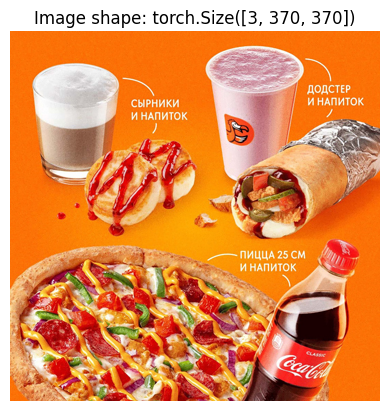

In [58]:
import torchvision

# Setup custom image path
custom_image_path = data_path / "1000_na_1000_kombo_dodo.jpg"

img = torchvision.io.read_image(custom_image_path)

# Plot custom image
plt.imshow(img.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {img.shape}")
plt.axis(False)

Original shape: torch.Size([3, 370, 370])
New shape: torch.Size([3, 64, 64])
Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])
Prediction logits: tensor([[ 3.7739, -4.5600, -2.9204]], device='cuda:0')
Prediction probabilities: tensor([[9.9852e-01, 2.3990e-04, 1.2361e-03]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


(-0.5, 63.5, 63.5, -0.5)

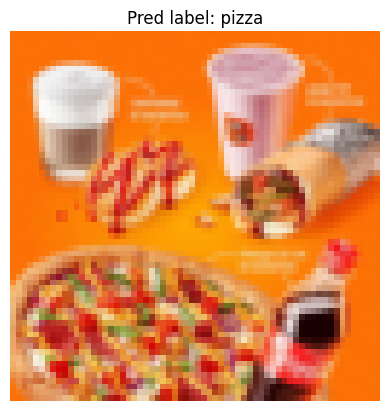

In [59]:
model_0_20_20_percent.eval()
with torch.inference_mode():
    img = img / 255

    # Create transform pipleine to resize image
    custom_image_transform = transforms.Compose([
        transforms.Resize((64, 64)),
    ])

    resized_img = custom_image_transform(img)

    # Print out original shape and new shape
    print(f"Original shape: {img.shape}")
    print(f"New shape: {resized_img.shape}")

    resized_img_with_batch_size = resized_img.unsqueeze(dim=0).to(device)

    # Print out different shapes
    print(f"Custom image transformed shape: {resized_img.shape}")
    print(f"Unsqueezed custom image shape: {resized_img_with_batch_size.shape}")

    pred = model_0_20_20_percent(resized_img_with_batch_size)

    # Print out prediction logits
    print(f"Prediction logits: {pred}")

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    pred_probs = torch.softmax(pred, dim=1)
    print(f"Prediction probabilities: {pred_probs}")

    # Convert prediction probabilities -> prediction labels
    pred_label = torch.argmax(pred_probs, dim=1)
    print(f"Prediction label: {pred_label}")

plt.imshow(resized_img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False)